# Plot effects of dicodon length and periodicity on mRNA levels

## Load libraries and define analysis-specific parameters

- We need to install both rsample and rasilabRtemplates in the Docker / Singularity container (or R conda environement?)

In [3]:
library(Biostrings)
library(tidyverse)
library(rasilabRtemplates)

insert_reads_cutoff <- 200 # The insert should get at least 200 reads across gRNA or mRNA
n_barcodes_cutoff <- 6 # The insert should have at least 6 barcodes across gRNA and mRNA after above cutoff

# Color-blind friendly palette. See http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:



## Read back barcode counts 

This is calculated in [plot_alignment_statistics.ipynb](plot_alignment_statistics.md).

In [20]:
barcode_counts <- read_tsv("../tables/sample_insert_barcode_counts.tsv.gz") %>% 
  rename(sample_type = sample_name, sample_name = cellline) %>% 
  filter(!is.na(sample_name))

barcode_counts  

Rows: 27840 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): sample_name, cellline
dbl (5): pool, insert_num, barcode_num, barcode_count, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sample_type,sample_name,pool,insert_num,barcode_num,barcode_count,linkage_count
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
stall4control4_grna,K562,6,5,12338,2551,1
stall4control4_grna,HeLa,5,4,7889,1779,303
stall4control4_grna,HeLa,5,5,7888,1628,431
stall4control4_grna,HeLa,5,2,7909,1107,223
stall4control4_grna,K562,6,3,10487,1041,333
⋮,⋮,⋮,⋮,⋮,⋮,⋮
stall4control4_t6,K562,6,2,11941,1,1
stall4control4_t6,K562,6,5,12003,1,1
stall4control4_t6,K562,6,7,12104,1,1


### Read insert annotations 

In [5]:

insert_annotations <- read_tsv("../../pool4_linkage/annotations/insert_annotations/stall4control4_linkage.tsv") %>% 
  print()

Rows: 8 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): group, insert_name, seq, rev_comp, insert_type
dbl (3): insert_num, pair, frame

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 8 × 8
  group insert_name seq                      rev_c…¹ inser…² inser…³  pair frame
  <chr> <chr>       <chr>                    <chr>   <chr>     <dbl> <dbl> <dbl>
1 human PS8         CGATGGCGATGGCGATGGCGATG… CCATCG… control       7     1     2
2 human RH8         ATGGCGATGGCGATGGCGATGGC… CGCCAT… stall         6     1     0
3 human FQ8         CTGAAACTGAAACTGAAACTGAA… TTTCAG… control       5     3     2
4 human SF8         GAAACTGAAACTGAAACTGAAAC… AGTTTC… stall         4     3     0
5 human QS8         ACTTTGACTTTGACTTTGACTTT… CAAAGT… control       3     2     2
6 human VK8         TTTGACTTTGACTTTGACTTTGA… GTCAAA… stall         2     2     0
7 human SKVF4       GTCAAAGTCAAAGTCAAAGTCAA… AGCAAA… control       1     4    NA
8 human SVKF4       GAATTTCACCGAAAACTTTACAC… AGCGTC… stall         0     4    NA
# … with abbreviated variable names ¹​rev_comp, ²​insert_type, ³​insert_num


### Function for bootstrap mRNA levels


In [6]:

calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna))
}

### Calculate mRNA levels of dicodons

- Log fold change is log2(mRNA/gRNA) and is median-normalized across the full library.

- Remove timecourse samples: we will analyze these seperately

In [8]:
install.packages('boot')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [22]:
lfc <- barcode_counts %>% 
  # select only gRNA and mRNA samples, no timecourse samples 
  filter(str_detect(sample_type, "rna")) %>%
  # rename sample_type to just "grna" or "mrna" 
  mutate(sample_type = str_remove(sample_type, "stall4control4_")) %>% 
  pivot_wider(names_from = sample_type, values_from = barcode_count) %>%
  drop_na() %>% 
  group_by(insert_num, sample_name) %>% 
  nest() %>%
  mutate(lfc = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=1000)$t)) %>%
  select(-data) %>%
  mutate(lfc_mean = map_dbl(lfc, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc, sd)) %>%
  select(-lfc) %>%
  inner_join(insert_annotations, by = "insert_num") %>%
  print()

# A tibble: 28 × 11
# Groups:   insert_num, sample_name [28]
   sample_name insert…¹ lfc_m…² lfc_sd group inser…³ seq   rev_c…⁴ inser…⁵  pair
   <chr>          <dbl>   <dbl>  <dbl> <chr> <chr>   <chr> <chr>   <chr>   <dbl>
 1 K562               5 -2.24   0.112  human FQ8     CTGA… TTTCAG… control     3
 2 HeLa               4 -1.00   0.0969 human SF8     GAAA… AGTTTC… stall       3
 3 HeLa               5 -0.166  0.0571 human FQ8     CTGA… TTTCAG… control     3
 4 HeLa               2 -2.47   0.131  human VK8     TTTG… GTCAAA… stall       2
 5 K562               3 -1.54   0.123  human QS8     ACTT… CAAAGT… control     2
 6 HeLa               3 -0.891  0.0723 human QS8     ACTT… CAAAGT… control     2
 7 HCT116             7 -0.507  0.140  human PS8     CGAT… CCATCG… control     1
 8 HCT116             5 -0.651  0.0889 human FQ8     CTGA… TTTCAG… control     3
 9 HeLa               7 -0.0166 0.0736 human PS8     CGAT… CCATCG… control     1
10 K562               7 -1.30   0.0872 human PS8


### Plot VK8, RH8, SF8 effects by cellline

- So! These effects look the same as our initial analysis! 

- This is a good sign, because it means my linakge trimming seems to have worked correctly (at least for these samples). I was worried that the trimming resulted in my scrambling the inserts with their +2 frameshifted controls, but it seems that I trimmed correctly! 

- However, I think the timecourse samples are still messed up (may need different trimming parameters), and it seems like I somehow lost the SVKF controls as well (at which step, I'm not sure). 

# A tibble: 24 × 12
   sample_name insert…¹ lfc_m…² lfc_sd group inser…³ seq   rev_c…⁴ inser…⁵  pair
   <chr>          <dbl>   <dbl>  <dbl> <chr> <chr>   <chr> <chr>   <chr>   <dbl>
 1 K562               5  -0.936 0.112  human FQ8     CTGA… TTTCAG… control     3
 2 HeLa               4  -0.984 0.0969 human SF8     GAAA… AGTTTC… stall       3
 3 HeLa               5  -0.150 0.0571 human FQ8     CTGA… TTTCAG… control     3
 4 HeLa               2  -2.45  0.131  human VK8     TTTG… GTCAAA… stall       2
 5 K562               3  -0.238 0.123  human QS8     ACTT… CAAAGT… control     2
 6 HeLa               3  -0.874 0.0723 human QS8     ACTT… CAAAGT… control     2
 7 HCT116             7   0     0.140  human PS8     CGAT… CCATCG… control     1
 8 HCT116             5  -0.144 0.0889 human FQ8     CTGA… TTTCAG… control     3
 9 HeLa               7   0     0.0736 human PS8     CGAT… CCATCG… control     1
10 K562               7   0     0.0872 human PS8     CGAT… CCATCG… control     1
# … with

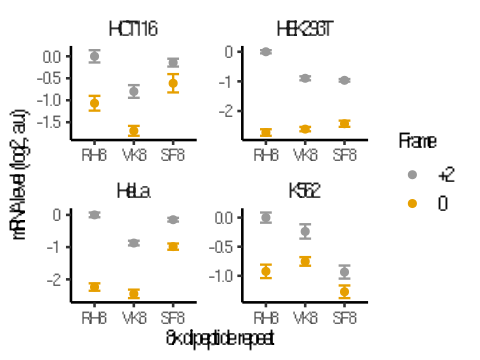

In [32]:
options(repr.plot.width=4, repr.plot.height=3)
# options(repr.plot.width=3, repr.plot.height=2) for manuscript

plot_data <- lfc %>% 
  filter(!is.na(frame)) %>% 
  mutate(frame = as.factor(frame)) %>% 
  mutate(frame = fct_rev(fct_recode(frame, "0" = "0", "+2" = "2"))) %>% 
  mutate(label = pair) %>% 
  group_by(sample_name, pair) %>% 
  mutate(label = insert_name[insert_type == "stall"]) %>% 
  ungroup() %>% 
  mutate(label = fct_reorder(label, pair)) %>% 
  group_by(sample_name) %>% 
  mutate(lfc_mean = lfc_mean - max(lfc_mean)) %>% 
  ungroup() %>% 
  print()
  
plot_data %>% 
  ggplot(aes(x = label, y = lfc_mean, 
             ymin = lfc_mean - lfc_sd, ymax = lfc_mean + lfc_sd, color = frame)) +
  facet_wrap(~ sample_name, scales = "free") + 
  scale_color_manual(values = cbPalette) +
  geom_errorbar(width = 0.3, show.legend = F) + 
  geom_point() +
  labs(x = "8x dipeptide repeat", y = "mRNA level (log2, a.u.)", color = "Frame")

# ggsave("../figures/multiple_celllline_dipeptide_mrna_effect.pdf")

# Plot SVKF4 effect by cell line

- Huh.. weird. Where did the control inserts for the SVKF test go? 

- Maybe these were somehow filtered out at an earlier step?

```{r, fig.width=2, fig.height=1.5}

In [35]:
## Where did we lose SKVF control?

insert_annotations
# SKVF insert number = 1. Is this present in the barcode counts? 
# SVKF beta insert is present
barcode_counts %>% filter(insert_num == 0) %>% print 
# SKVF alpha control insert is not present.. 
barcode_counts %>% filter(insert_num == 1) %>% print 
# Okay, so this was lost at an earlier processing step. Either in the barcode count generation script, or at the linkage stage. 

group,insert_name,seq,rev_comp,insert_type,insert_num,pair,frame
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
human,PS8,CGATGGCGATGGCGATGGCGATGGCGATGGCGATGGCGATGGCGATGG,CCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCG,control,7,1,2
human,RH8,ATGGCGATGGCGATGGCGATGGCGATGGCGATGGCGATGGCGATGGCG,CGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCAT,stall,6,1,0
human,FQ8,CTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAA,TTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAG,control,5,3,2
human,SF8,GAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACT,AGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTC,stall,4,3,0
human,QS8,ACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTG,CAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGT,control,3,2,2
human,VK8,TTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGAC,GTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAA,stall,2,2,0
human,SKVF4,GTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAA,AGCAAAGTCTTCTCCAAGGTTTTTAGTAAGGTATTTTCGAAAGTGTTC,control,1,4,NA
human,SVKF4,GAATTTCACCGAAAACTTTACACTAAACTTAACGGAGAATTTGACGCT,AGCGTCAAATTCTCCGTTAAGTTTAGTGTAAAGTTTTCGGTGAAATTC,stall,0,4,NA


# A tibble: 562 × 7
   sample_type         sample_name  pool insert_num barcode_num barcod…¹ linka…²
   <chr>               <chr>       <dbl>      <dbl>       <dbl>    <dbl>   <dbl>
 1 stall4control4_grna HeLa            5          0        7907      525     227
 2 stall4control4_grna K562            6          0       10475      497     394
 3 stall4control4_grna HeLa            5          0        8207      419     107
 4 stall4control4_grna K562            6          0       10552      400     243
 5 stall4control4_grna HeLa            5          0        8057      395     139
 6 stall4control4_grna K562            6          0       11676      372       7
 7 stall4control4_grna HeLa            5          0        7992      368     160
 8 stall4control4_grna HeLa            5          0        8866      338      41
 9 stall4control4_grna HeLa            5          0        8014      335     151
10 stall4control4_grna HeLa            5          0        8242      326     100
# … with

In [36]:
lfc

plot_data <- lfc %>% print %>%
  filter(is.na(frame)) %>% print 
  group_by(sample_name) %>% 
  mutate(lfc_mean = lfc_mean - lfc_mean[insert_type == "control"]) %>% 
  ungroup() %>% 
  print()
  
plot_data %>% 
  ggplot(aes(x = sample_name, y = lfc_mean, 
             ymin = lfc_mean - lfc_sd, ymax = lfc_mean + lfc_sd, color = insert_name)) +
  scale_color_manual(values = cbPalette) +
  geom_errorbar(width = 0.3, show.legend = F) + 
  geom_point() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Cell line", y = "mRNA level (log2, a.u.)", color = "")

# ggsave("../figures/multiple_celllline_svkf_mrna_effect.pdf")

sample_name,insert_num,lfc_mean,lfc_sd,group,insert_name,seq,rev_comp,insert_type,pair,frame
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
K562,5,-2.2388154,0.11229709,human,FQ8,CTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAA,TTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAG,control,3,2
HeLa,4,-1.0006779,0.09687072,human,SF8,GAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACT,AGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTC,stall,3,0
HeLa,5,-0.1661491,0.05705627,human,FQ8,CTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAA,TTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAG,control,3,2
HeLa,2,-2.4670920,0.13141604,human,VK8,TTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGAC,GTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAA,stall,2,0
K562,3,-1.5410854,0.12339445,human,QS8,ACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTG,CAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGT,control,2,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
HCT116,4,-1.12039682,0.2088920,human,SF8,GAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACTGAAACT,AGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTC,stall,3,0
HCT116,2,-2.20278157,0.1122026,human,VK8,TTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGACTTTGAC,GTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAA,stall,2,0
HEK293T,0,-0.52844118,0.3784795,human,SVKF4,GAATTTCACCGAAAACTTTACACTAAACTTAACGGAGAATTTGACGCT,AGCGTCAAATTCTCCGTTAAGTTTAGTGTAAAGTTTTCGGTGAAATTC,stall,4,NA


# A tibble: 28 × 11
# Groups:   insert_num, sample_name [28]
   sample_name insert…¹ lfc_m…² lfc_sd group inser…³ seq   rev_c…⁴ inser…⁵  pair
   <chr>          <dbl>   <dbl>  <dbl> <chr> <chr>   <chr> <chr>   <chr>   <dbl>
 1 K562               5 -2.24   0.112  human FQ8     CTGA… TTTCAG… control     3
 2 HeLa               4 -1.00   0.0969 human SF8     GAAA… AGTTTC… stall       3
 3 HeLa               5 -0.166  0.0571 human FQ8     CTGA… TTTCAG… control     3
 4 HeLa               2 -2.47   0.131  human VK8     TTTG… GTCAAA… stall       2
 5 K562               3 -1.54   0.123  human QS8     ACTT… CAAAGT… control     2
 6 HeLa               3 -0.891  0.0723 human QS8     ACTT… CAAAGT… control     2
 7 HCT116             7 -0.507  0.140  human PS8     CGAT… CCATCG… control     1
 8 HCT116             5 -0.651  0.0889 human FQ8     CTGA… TTTCAG… control     3
 9 HeLa               7 -0.0166 0.0736 human PS8     CGAT… CCATCG… control     1
10 K562               7 -1.30   0.0872 human PS8

ERROR: Error in group_by(sample_name): object 'sample_name' not found
